<a href="https://colab.research.google.com/github/cserik/DeepLearningNHF/blob/main/Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from PIL import Image
from tempfile import TemporaryFile

**<--------Copy kaggle.json file from github to files tab(content directory)**

---



In [ ]:
#our dataset is from kaggle
!pip install kaggle

In [ ]:
#we created an API token for kaggle (kaggle.json file)
#make a directory with a name : kaggle
!mkdir ~/.kaggle

In [ ]:
#copy kaggle.json file to kaggle 
!cp kaggle.json ~/.kaggle/

In [ ]:
#change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download the dataset from kaggle
!kaggle datasets download -d badasstechie/celebahq-resized-256x256

 97% 275M/283M [00:02<00:00, 149MB/s]
100% 283M/283M [00:02<00:00, 140MB/s]


In [ ]:
!unzip celebahq-resized-256x256.zip

In [ ]:
base_dir = 'celeba_hq_256' 

#get the name of the images
train_fnames = os.listdir(base_dir)
print(train_fnames[:10])

['29259.jpg', '10094.jpg', '26611.jpg', '10607.jpg', '07211.jpg', '10465.jpg', '18142.jpg', '28717.jpg', '18312.jpg', '06546.jpg']


In [ ]:
image_count = len(train_fnames)
print("Number of images:" ,image_count)

Number of images: 30000


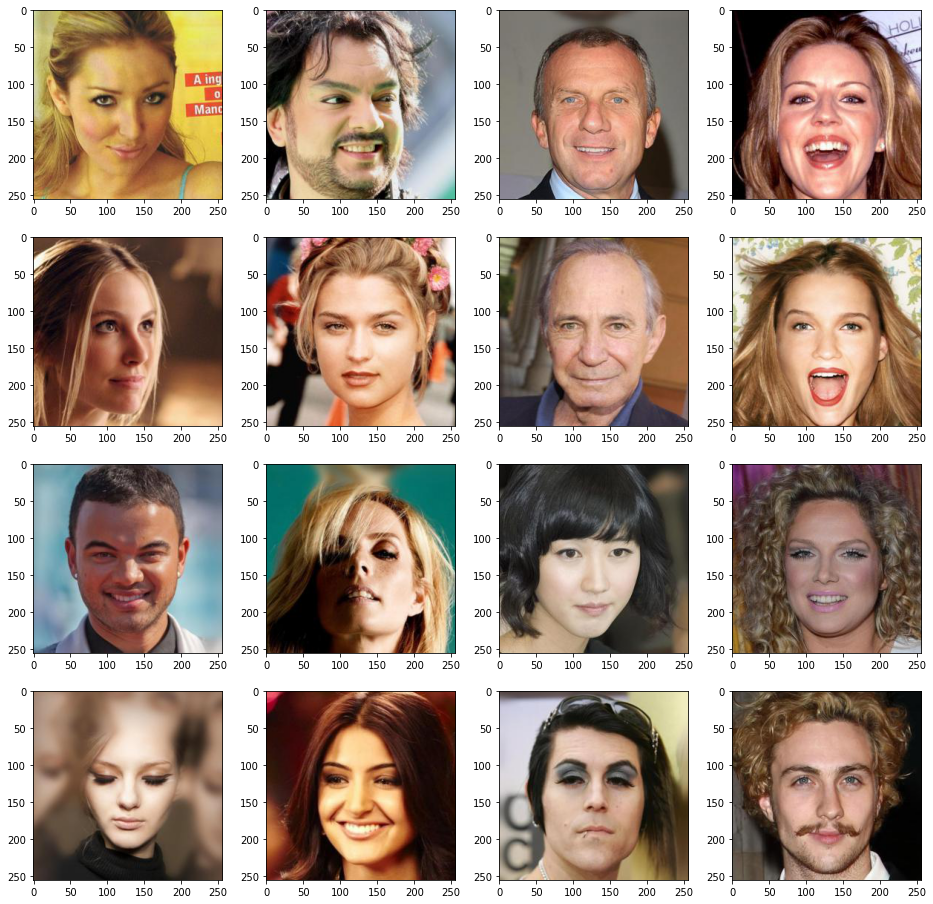

In [ ]:
#plot some images from the dataset
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_images = [os.path.join(base_dir, fname) for fname in train_fnames[:int(ncols*nrows)]]

for i, img_path in enumerate(next_images):
    sp = plt.subplot(nrows, ncols, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [ ]:
def normalize(x):
	# extract numpy array
	X = x
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	#[0,1] scale was too dark
	#X = X / 255.0
	X = (X - 127.5) / 127.5
	return X

In [ ]:
# load an image as an rgb numpy array
def load_image(filename):
	# load image from file
	image = Image.open(filename)
	# convert to RGB
	image = image.convert('RGB')
	# convert to array
	pixels = np.asarray(image)
	return normalize(pixels)

In [ ]:
# load images to array
def load_to_array(directory, size):
	faces = list()
	# enumerate files
	for filename in os.listdir(directory):
		# load the image
		pixels = load_image(directory +'/'+ filename)
		# store
		faces.append(pixels)
		#print(len(faces), face.shape)
		if len(faces) >= size:
			break
	return np.asarray(faces)

In [ ]:
# load and extract all faces
all_faces = load_to_array(base_dir, 2000)
print('Loaded: ', all_faces.shape)

Loaded:  (2000, 256, 256, 3)


In [ ]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, Flatten, BatchNormalization, Add, LeakyReLU,UpSampling2D, Reshape, Layer
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import backend

In [ ]:
# weighted sum output
class WeightedSum(Add):
	# init with default value
	def __init__(self, alpha=0.0, **kwargs):
		super(WeightedSum, self).__init__(**kwargs)
		self.alpha = backend.variable(alpha, name='ws_alpha')
 
	# output a weighted sum of inputs
	def _merge_function(self, inputs):
		# only supports a weighted sum of two inputs
		assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
		output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
		return output

	def get_config(self):
		config = super().get_config().copy()
		config.update({
				'alpha': self.alpha,
		})
		return config

In [ ]:
# add a discriminator block
def add_discriminator_block(old_model, n_input_layers=3):
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	# get shape of existing model
	in_shape = list(old_model.input.shape)
	# define new input shape as double the size
	input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
	in_image = Input(shape=input_shape)
	# define new input processing layer
	d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# define new block
	d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	#d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	#d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = AveragePooling2D()(d)
	block_new = d
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model1 = Model(in_image, d)
	# compile model
	model1.compile(loss='mse', optimizer=Adam(lr=0.00005, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# downsample the new larger image
	downsample = AveragePooling2D()(in_image)
	# connect old input processing to downsampled new input
	block_old = old_model.layers[1](downsample)
	block_old = old_model.layers[2](block_old)
	# fade in output of old model input layer with new input
	d = WeightedSum()([block_old, block_new])
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model2 = Model(in_image, d)
	# compile model
	model2.compile(loss='mse', optimizer=Adam(lr=0.00005, beta_1=0, beta_2=0.99, epsilon=10e-8))
	return [model1, model2]
 
# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4,4,3)):
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	model_list = list()
	# base model input
	in_image = Input(shape=input_shape)
	# conv 1x1
	d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 3x3 (output block)
	#d = MinibatchStdev()(d)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	#d=BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 4x4
	d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	#d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# dense output layer
	d = Flatten()(d)
	out_class = Dense(1)(d)
	# define model
	model = Model(in_image, out_class)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.00005, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_discriminator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

In [ ]:
#generator 
# add a generator block
def add_generator_block(old_model):
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	# get the end of the last block
	block_end = old_model.layers[-2].output
	# upsample, and define new block
	upsampling = UpSampling2D()(block_end)
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
	#g = BatchNormalization()(g)
	#g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	#g = BatchNormalization()(g)
	#g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# add new output layer
	out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	# define model
	model1 = Model(old_model.input, out_image)
	# get the output layer from old model
	out_old = old_model.layers[-1]
	# connect the upsampling to the old output layer
	out_image2 = out_old(upsampling)
	# define new output image as the weighted sum of the old and new models
	merged = WeightedSum()([out_image2, out_image])
	# define model
	model2 = Model(old_model.input, merged)
	return [model1, model2]
 
# define generator models
def define_generator(latent_dim, n_blocks, in_dim=4):
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = max_norm(1.0)
	model_list = list()
	# base model latent input
	in_latent = Input(shape=(latent_dim,))
	# linear scale up to activation maps
	g  = Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
	g = Reshape((in_dim, in_dim, 128))(g)
	# conv 4x4, input block
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	#g = BatchNormalization()(g)
	#g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# conv 3x3
	g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	#g = BatchNormalization()(g)
	#g = PixelNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# conv 1x1, output block
	out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	# define model
	model = Model(in_latent, out_image)
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_generator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

In [ ]:
# define composite models for training generators via discriminators
def define_composite(discriminators, generators):
	model_list = list()
	# create composite models
	for i in range(len(discriminators)):
		g_models, d_models = generators[i], discriminators[i]
		# straight-through model
		d_models[0].trainable = False
		model1 = Sequential()
		model1.add(g_models[0])
		model1.add(d_models[0])
		model1.compile(loss='mse', optimizer=Adam(lr=0.00005, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# fade-in model
		d_models[1].trainable = False
		model2 = Sequential()
		model2.add(g_models[1])
		model2.add(d_models[1])
		model2.compile(loss='mse', optimizer=Adam(lr=0.00005, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# store
		model_list.append([model1, model2])
	return model_list

In [ ]:
# generate mini batch
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images and normalization
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = -ones((n_samples, 1))
	return X, y

In [ ]:
# update the alpha value on each instance of WeightedSum
def update_fadein(models, step, n_steps):
	# calculate current alpha (linear from 0 to 1)
	alpha = step / float(n_steps - 1)
	# update the alpha for each model
	for model in models:
		for layer in model.layers:
			if isinstance(layer, WeightedSum):
				backend.set_value(layer.alpha, alpha)

In [ ]:
# train a generator and discriminator
def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein=False):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# update alpha for all WeightedSum layers when fading in new blocks
		if fadein:
			update_fadein([g_model, d_model, gan_model], i, n_steps)
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))

In [ ]:
# scale images to preferred size
def scale_dataset(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

In [ ]:
def summarize_performance(status, g_model, latent_dim, n_samples=25):
	# devise name
	gen_shape = g_model.output_shape
	name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
	# generate images
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# normalize pixel values to the range [0,1]
	X = (X - X.min()) / (X.max() - X.min())
	# plot real images
	square = int(sqrt(n_samples))
	for i in range(n_samples):
		pyplot.subplot(square, square, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X[i])
	# save plot to file
	filename1 = 'plot_%s.png' % (name)
	pyplot.savefig(filename1)
	pyplot.close()
	#save the generator model
	filename2 = 'model_%s.h5' % (name)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
	# fit the baseline model
	g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
	# scale dataset to appropriate size
	gen_shape = g_normal.output_shape
	scaled_data = scale_dataset(dataset, gen_shape[1:])
	print('Scaled Data', scaled_data.shape)
	# train normal or straight-through models
	train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0])
	summarize_performance('tuned', g_normal, latent_dim)
	# process each level of growth
	for i in range(1, len(g_models)):
		# retrieve models for this level of growth
		[g_normal, g_fadein] = g_models[i]
		[d_normal, d_fadein] = d_models[i]
		[gan_normal, gan_fadein] = gan_models[i]
		# scale dataset to appropriate size
		gen_shape = g_normal.output_shape
		scaled_data = scale_dataset(dataset, gen_shape[1:])
		print('Scaled Data', scaled_data.shape)
		# train fade-in models for next level of growth
		train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i], True)
		# train normal or straight-through models
		train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i])
		summarize_performance('tuned', g_normal, latent_dim)

In [ ]:
from skimage.transform import resize
from numpy import asarray
from numpy.random import randn
# example of progressive growing gan on celebrity faces dataset
from math import sqrt
from numpy import load
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from skimage.transform import resize
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.models import load_model
import datetime

# number of growth phase, e.g. 3 = 16x16 images
n_blocks = 4
# size of the latent space
latent_dim = 200
# define models
d_models = define_discriminator(n_blocks)
# define models
g_models = define_generator(latent_dim, n_blocks)
# define composite models
gan_models = define_composite(d_models, g_models)

# load image data
dataset = all_faces
# train model

n_batch = [16, 16, 16, 8, 4]
#n_batch = [16, 16]
n_epochs = [5, 8, 8, 10, 10]
#n_epochs = [5, 8]

#best with mse and only batchnorm at the generator
train(g_models, d_models, gan_models, dataset, latent_dim, n_epochs, n_epochs, n_batch)
# save generator models
#save_generator_models(g_models)
# save and plot results
#plot_result(g_models, n_blocks, latent_dim, 3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Scaled Data (2000, 4, 4, 3)
>1, d1=1.000, d2=1.002 g=1.000
>2, d1=0.997, d2=1.001 g=1.000
>3, d1=0.991, d2=1.001 g=1.000
>4, d1=0.985, d2=1.001 g=1.000
>5, d1=0.983, d2=1.001 g=1.000
>6, d1=0.977, d2=1.001 g=1.000
>7, d1=0.973, d2=1.002 g=1.000
>8, d1=0.958, d2=1.002 g=1.000
>9, d1=0.938, d2=1.003 g=1.000
>10, d1=0.948, d2=1.003 g=1.000
>11, d1=0.946, d2=1.003 g=0.999
>12, d1=0.926, d2=1.004 g=0.999
>13, d1=0.930, d2=1.006 g=0.999
>14, d1=0.900, d2=1.006 g=0.997
>15, d1=0.897, d2=1.008 g=0.996
>16, d1=0.879, d2=1.010 g=0.996
>17, d1=0.904, d2=1.010 g=0.994
>18, d1=0.861, d2=1.014 g=0.993
>19, d1=0.853, d2=1.016 g=0.991
>20, d1=0.835, d2=1.019 g=0.988
>21, d1=0.818, d2=1.022 g=0.987
>22, d1=0.817, d2=1.027 g=0.984
>23, d1=0.792, d2=1.032 g=0.980
>24, d1=0.765, d2=1.035 g=0.978
>25, d1=0.761, d2=1.039 g=0.975
>26, d1=0.740, d2=1.046 g=0.970
>27, d1=0.728, d2=1.053 g=0.971
>28, d1=0.677, d2=1.053 g=0.966
>29, d1=0.670, d2=1.061 g=0.963
>30, d1=0.678, d2=1.063 g=0.960
>31, d1=0.612, d2=1.0